In [1]:
from datetime import timedelta

import pandas as pd

In [2]:
df = pd.read_csv("../20240430_Messages.csv", sep="|")
df.Datetime = pd.to_datetime(df.Datetime)

In [3]:
def top_k_senders(df, freq, k=5):
    # Resample and count the number of messages per sender
    resampled = df.groupby("Sender").resample(freq).count()

    # Sort and group by the period (week or month)
    sorted_grouped = (
        resampled["Message"]
        .reset_index()
        .sort_values(["Datetime", "Message"], ascending=[True, False])
        .groupby("Datetime")
    )

    # Get the top K senders for each period
    top_senders = sorted_grouped.head(k)

    return top_senders


top_df = df.set_index("Datetime")
# Top K senders per week
k = 6
top_senders_weekly = top_k_senders(top_df, "W", k)
print(f"Top {k} senders per week:")
display(top_senders_weekly[-20:])

Top 6 senders per week:


,Sender,Datetime,Message
15965,Sumanth Raghavendra,2024-04-14,8
9260,Nirant K,2024-04-14,7
5291,Dr. Pratik Desai KissanAI,2024-04-21,64
9780,Paras Chopra Wingify,2024-04-21,41
751,Abhishek Mishra,2024-04-21,38
1073,Adithya S K PESIT,2024-04-21,35
13394,Sankalp Shubham,2024-04-21,35
929,Adarsh GenAI WhatsApp Group,2024-04-21,31
15666,Sthit Generative AI WhatsApp Group,2024-04-28,29
9262,Nirant K,2024-04-28,23


In [4]:
# Top K senders per month
top_senders_monthly = top_k_senders(top_df, "M", k)
print(f"\nTop {k} senders per month:")
top_senders_monthly

/var/folders/b4/grpbcmrd36gc7q5_11whbn540000gn/T/ipykernel_57190/3879787554.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = df.groupby("Sender").resample(freq).count()



Top 6 senders per month:


,Sender,Datetime,Message
2342,Nirant K,2023-03-31,176
4009,Sudharshan GenAI,2023-03-31,111
3901,Soumyadeep Mukherjee,2023-03-31,60
501,Amogh V,2023-03-31,50
1172,Dev Aggarwal,2023-03-31,36
...,...,...,...
2355,Nirant K,2024-04-30,70
2490,Paras Chopra Wingify,2024-04-30,68
3979,Sthit Generative AI WhatsApp Group,2024-04-30,62
2753,Priyesh OnFinance,2024-04-30,56


In [5]:
df.columns

Index(['Datetime', 'Sender', 'Message'], dtype='object')

In [6]:
# Assuming 'df' is the DataFrame with the columns 'Sender', 'Datetime', and 'Message'
# Make sure the 'Datetime' column is set as the index
df.set_index("Datetime", inplace=True)
df.sort_index(inplace=True)

# Resample DataFrame to a weekly frequency
weekly_data = df.resample("M").count()

# Initialize lists to store the results
new_senders = []
active_senders = []
churned_senders = []

# Initialize sets for active and churned senders
current_senders = set()
previous_senders = set()
churned = set()

# Time window to consider a sender as churned (21 days)
churn_window = timedelta(days=21)

# Iterate through each week
for week in weekly_data.index:
    # Get the data for the current week
    current_week_data = df.truncate(
        before=week - timedelta(weeks=1) + timedelta(seconds=1), after=week
    )

    # Calculate new, active, and churned senders for the current week
    new_senders_count = 0
    active_senders_count = 0
    churned_senders_count = 0

    for sender in current_week_data["Sender"].unique():
        # Check if the sender is new
        if sender not in current_senders and sender not in previous_senders:
            new_senders_count += 1
            current_senders.add(sender)

        # Check if the sender is active
        if sender in current_senders or sender in previous_senders:
            active_senders_count += 1
            current_senders.add(sender)

    # Update churned senders
    for sender in previous_senders:
        if (
            sender not in current_senders
            and (week - df[df["Sender"] == sender].index[-1]) > churn_window
        ):
            churned.add(sender)

    # Store the results in the lists
    new_senders.append(new_senders_count)
    active_senders.append(active_senders_count)
    churned_senders.append(len(churned))

    # Update previous_senders for the next iteration
    previous_senders.update(current_senders)
    current_senders.clear()

# Create a DataFrame with the results
result_df = pd.DataFrame(
    {
        "Date": weekly_data.index,
        "New Senders": new_senders,
        "Active Senders": active_senders,
        "Churned Senders": churned_senders,
    }
)
result_df.set_index("Date", inplace=True)

/var/folders/b4/grpbcmrd36gc7q5_11whbn540000gn/T/ipykernel_57190/1664688818.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_data = df.resample("M").count()


In [7]:
display(result_df[-6:])
# display(result_df.style.hide(axis="index"))

,New Senders,Active Senders,Churned Senders
Date,,,
2023-11-30,60,202,446
2023-12-31,29,120,536
2024-01-31,27,134,663
2024-02-29,47,165,708
2024-03-31,31,137,794
2024-04-30,13,119,918


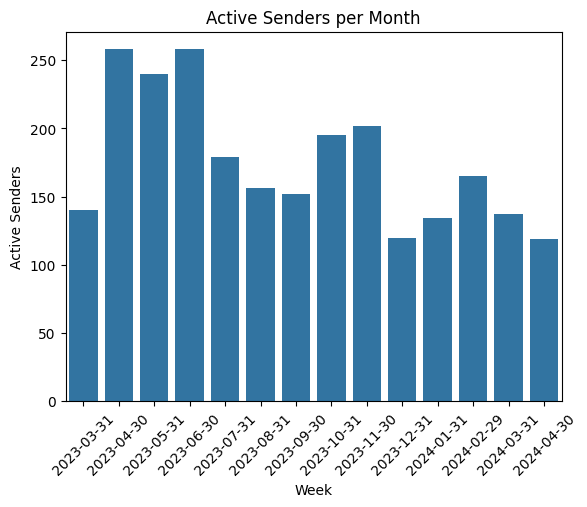

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the active senders for each week
sns.barplot(x=result_df.index, y=result_df["Active Senders"])
plt.xlabel("Week")
plt.ylabel("Active Senders")
plt.title("Active Senders per Month")
plt.xticks(rotation=45)
plt.show()